# Chirrup

Authors: Hasan Khan, Tyler Robbins
 
Lab: MelizaLab

In this program, membrane voltage data obtained from the Zebra Finch HVC (high vocal center) cell recordings
is used to fit parameters for the adaptive exponential integrate-and-fire model (AdEx). Using a monte carlo markhov chain algorithm via the emcee python module, optimized parameter values for the AdEx model and their posterior
distributions are calculated and plotted. 

Further information on emcee can be found at: http://dan.iel.fm/emcee/current/

More information on custom packages, libraries and dependencies can be found here: https://github.com/melizalab

----------------------------------------------------------------------------------------------------------

# Dependencies

Importing packages and dependencies:

In [28]:
from __future__ import division
from __future__ import print_function

# data assimilation packages
import numpy as np
import emcee
import cneurons as cn
import quickspikes as qs
import pyspike as spk
import time
from scipy import signal

#plotting packages
from matplotlib.pyplot import * # plotting functions
import seaborn as sns           # data visualization package
import pandas as pd             # data analysis and manipulation package
%matplotlib inline

# set up the plots to look not awful
clr_plt = sns.color_palette('cubehelix',4)
sns.set_style('white')
rcParams['figure.figsize'] = (16,10)

---------------------------------------------------------------------------------------------------------
# Initializations

This cell initilizes the adex neuron and applies an injected current to the neuron. 
Plots out a biologoical voltage response (blue) to the same injected current, overlayed on
the Adex model's voltage response (green). The applied current is also plotted below:

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


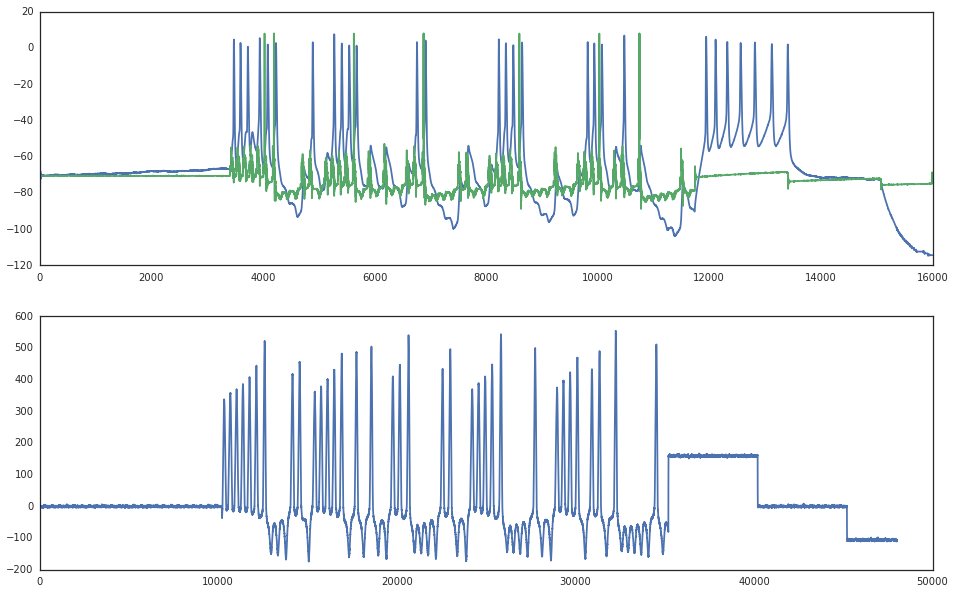

In [3]:

## loading voltage and applied current data
vpath = 'neurofit/data/real/20120406_1_3_15v.dat'
ipath = 'neurofit/data/real/20120406_1_3_15i.dat'

## data loading and integrator settings
iscale = 1000
dsample = 3
res = 0.02
dt = 0.06
steps = 16000
maxtau = 150

## spike detector
spikethresh = 0
spikewidth = 10
det = qs.detector(spikethresh, spikewidth)

## load the voltage and applied current data, down-sampling if necessaryv_all = np.loadtxt(vpath)  
## if not dsample else signal.decimate(np.loadtxt(vpath),dsample)
v_all = np.loadtxt(vpath) if not dsample else signal.decimate(np.loadtxt(vpath),dsample)
v = v_all[:steps] # length: 1600. Limits data recording to only first 16000 steps

iapp_all = np.loadtxt(ipath) #if not dsample else signal.decimate(np.loadtxt(ipath)*iscale,dsample)

#print ('iapp size:' , len(iapp_all))


iapp_all = np.loadtxt(ipath)*iscale

iapp = iapp_all[:(steps*dt)/res]

#print ('iapp_all w scale: ', iapp_all)

## determine in milliseconds the duration of the full voltage data set and the portion used for assimilation
allduration = len(v_all)*dt
duration = len(v)*dt

## create a list of spike times for the full voltage data set and portion used for assimilation
vallspikes = det.send(v_all)
vspikes = det.send(v)

## convert spike times into format used by pyspike
vs = spk.SpikeTrain(vspikes,[0,steps])
vas = spk.SpikeTrain(vallspikes,[0,allduration])

subplot(211)
plot(v) # blue, data spikes
ade = cn.adex()
ade.h = 8
ade.apply_current(iapp,res)
plot(ade.simulate(duration,dt)[:,0]) # green, Adex model spikes (without any optimization)

subplot(212)
plot(iapp) ## plotting applied current


----------------------------------------------------------------------------------------------------
# Probability functions

In this cell, we define the prior, likelihood and probability functions central to using MCMC. These
functions are called by emcee when the sampler runs. Function descriptions:

1. lnprior
       
       Passed: theta (tuple variable from passed in from emcee. Populates the AdEx equations' parameters)
   
       Description: Bounds inputted parameter values (theta) within known/plausible ranges. Acts as 
       a "sieve" on parameter inputs. When the parameter values - as calculated  and passed in by 
       emcee - fit within these ranges, lnprior returns 0. Else, lnprior returns -inf. 

2. lnlike
       
       Passed: theta, data (biologicial voltage output in response to injected current), iapp (injected current)
       
       Description: Applies the given injected current (iapp) on an adex model with the currently 
       passed in emcee paramaters (theta). Calculates least-mean-squares difference between the biological
       voltage response (data) and the AdEx models' response to the injected current. Spike time difference 
       is also recorded. Since we care more about neural spike timing for the HVC than exact spike shapes, 
       we chose to use the spike timing as the output. Note that the spike timing and LMS value can be scaled
       and combined as output, which would account for both spike timing and shape accuracy.
       
3. lnprob
       
       Passed: theta, data (biologicial voltage output in response to injected current), iapp (injected current)
       Description: Uses lnprior to discard any theta values outside lnprior's defined bounds.  Returns the 
       likelihood of a certain parameter set

In [23]:

def lnprior(theta):
    C, gl, el, delt, vt, tw, a, vr, b = theta
 
    # bounds on the uniform prior distributions.
    if (   
            1.0 < C < 500 and 
            0.0  < gl < 30.0 and
            -120 < el < -20 and 
            0.1 < delt < 10 and
            -70 < vt < 0 and
            10 < tw < 210 and
            -10 < a < 10 and  
            -80.0 < vr < 0 and
            0.0 < b < 500
        ):
            return 0.0
     
    return -np.inf

# likelihood of the data given the parameters
def lnlike(theta, data, iapp):
    
    C, gl, el, delt, vt, tw, a, vr, b = theta
    
    # integrating the model with parameters sample
    hrn = cn.adex(C,gl, el, delt, vt, tw, a, vr, b)
    hrn.h = 8
    hrn.apply_current(iapp,res)
    model = hrn.simulate(duration,dt)[:,0]
    
    # Note: Parameters a and b are fixed because they determine spike shape, 
    # which is irrelevant to the SPIKE sync cost function. a and b are fixed
    # to values that produce a standard spike shape.
    
    # estimating the spike times
    mspikes = det.send(model)
    ms = spk.SpikeTrain(mspikes,[0,len(iapp)])
    
    # compare model spike times to spike times fom the real neuron   
    out1 = np.log(spk.spike_sync(vs,ms,max_tau=maxtau)) 
    
    # compare model voltage recording with biological voltage output. An LMS calculation 
    out2 = -np.sum((data-model)**2) 
    
    return  out1


# probability of the paramters given the data
def lnprob(theta, data, iapp):
    
    # calculate prior probability of parameter values
    lp = lnprior(theta)
   
    
    # throw out sample if parameters are out of bounds
    if not np.isfinite(lp):
        return -np.inf
    
    # calculate likelihood of the data given the parameters
    ln = lnlike(theta, data, iapp)
    
    if (ln==ln):
        return lp + ln
    else:
        return -np.inf


--------------------------------------------------------------------------------------------------------

# Emcee Sampler

In this cell, we initialize and run the emcee sampler. The steps for running the emcee sampler:

1. First, we initialize the number of walkers (essentially seperate Metropolis hasting chains) and the ndim 
   dimension value (number of parameters)

2. Next, we create the absolute starting positions for the AdEx parameters using the "ball method," which creates
   a tiny Gaussian ball of values around the maximum likelihoods of the given parameters. Note that even though these
   balls start close to estimated maximum likelihoods, they quickly explore the rest of the state space. The ball        method is used as opposed to the "blanket method," where starting value parameters are picked at random from a        uniform distribution bounded by previously defined lnprior bounds.
   
3. Now, the emcee sampler is run using sampler. The sampler is initialized in the following statement:
       
       sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[v,iapp],threads=8)
   
   The sampler is run in the next statement:
   
       pos, prob, state = sampler.run_mcmc(startPos, n,storechain=True)
       
   Here, the sampler takes in the starting position (startPos) and the number of steps to run (n). It returns
   pos ("a list of the current positions of the walkers in the parameter space" - emcee documentation), prob ("the        list of log posterior probabilities for the walkers at positions given by pos" - emcee documentation) and state        (the current state of the random number generator).
   
   The first time emcee is run, it is run for 500 steps. This is the meat of the calculation, or the "burning in"
   of the markhov chains, allowing the walkers to explore the state space and converge on optimized parameter values.    After reseting the sampler, emcee is run again for a single step. The mean acceptance value (acceptance values tell    us the fraction of steps accepted for each walker) over all walkers is recorded and printed. 
   
   
   
   

In [24]:

# setting the number of walkers and dimensions
ndim, nwalkers = 9, 1000

# BALL METHOD: 

start = [ 2.20300000e+01, 2.17000000e+00,  -80,   1.10000000e-01,
  -5.32000000e+01,   2.28500000e+01,  -6.00000000e-02,  -6.77900000e+01,
  5.07500000e+01]

## creating a ball of walkers around the starting point:
startPos = emcee.utils.sample_ball(start,[2]*len(start),size=nwalkers)


## BLANKET METHOD:
'''

startPos = np.concatenate((np.random.uniform(1.0,500,(nwalkers,1)),
                        np.random.uniform(0.0 , 30.0, (nwalkers,1)),
                        np.random.uniform(-120, -20, (nwalkers,1)),
                        np.random.uniform(0.1, 10, (nwalkers,1)),
                        np.random.uniform(-70, 0, (nwalkers,1)),
                        np.random.uniform(10, 210, (nwalkers,1)),
                        np.random.uniform(-10, 10, (nwalkers,1)),
                        np.random.uniform(-80.0, 0, (nwalkers,1)),
                        np.random.uniform(0,500,(nwalkers,1))),1)

'''

# setting up the sampler to run in parallel on 12 cores

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[v,iapp],threads=8)

n = 200

%time pos, prob, state = sampler.run_mcmc(startPos, n, storechain=True)
print("Finished burning in chains")

# sampling the posterior distribution of the parameters.

n = 1
pos2, prob2, state2 = sampler.run_mcmc(pos, n, storechain=True)

print("Finished Sampling")
print("Acceptance:")
print(np.mean(sampler.acceptance_fraction))


CPU times: user 6.67 s, sys: 4.92 s, total: 11.6 s
Wall time: 2min 15s
Finished burning in chains
Finished Sampling
Acceptance:
0.201064676617


--------------------------------------------------------------------------------------------------------

# Plotting posterior distributions

With the parameter optimizations complete, it is time to visualize the posterior distribution of these parameters, which will help determine the optimal parameter values. 

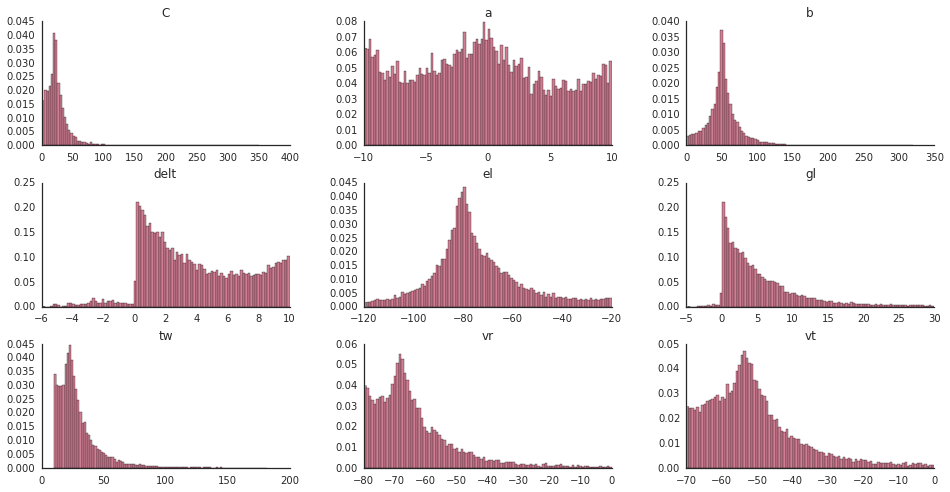

In [25]:
# load plotting packages
from matplotlib.pyplot import * # plotting package
import seaborn as sns          # data visualization package
import pandas as pd            # data analysis and manipulation package

# tell IPython to show plots in the notebook
%matplotlib inline

# set up the plots to look not awful
clr_plt = sns.color_palette('cubehelix',4)
sns.set_style('white')

# put the MCMC trace into nice and tidy dataframe
mcmc_samples = pd.DataFrame(sampler.flatchain, columns = ["C", "gl", "el", "delt", "vt", "tw", "a", "vr", "b"])
mcmc_samples = np.round(mcmc_samples,2)

# plot a histogram of samples
hists = mcmc_samples.hist(bins=100,color=clr_plt[2],figsize=(16, 8),normed=True,grid='off')
jointHist = np.histogram2d(sampler.flatchain[:,1],sampler.flatchain[:,3], bins = 300)

# remove ugly and useless spines
sns.despine()

----------------------------------------------------------------------------------------

# Finding optimized parameter values

This cell calculates and prints the mean, median, and mode parameter values from the 
parameter posterior distributions

In [26]:
# get the median parameter values from the posterior distribution
mean = np.asarray(mcmc_samples.mean())
med = np.asarray(mcmc_samples.median())
mod = np.asarray(mcmc_samples.mode())[0]
best = sampler.flatchain[sampler.flatlnprobability.argmax()]

mC, mgl, mel, mdelt, mvt, mtw, ma, mvr, mb = best

print(" Parameter means:")
print(np.round(mean,2))
print("\n Parameter medians:")
print(med)
print("\n Parameter modes:")
print(mod)
print("\n Parameter bests:")
print(np.round(best,2))

 Parameter means:
[ 25.47   5.39 -74.99   3.94 -51.23  28.78  -0.43 -63.98  52.81]

 Parameter medians:
[ 21.9    3.65 -78.13   3.32 -53.28  24.32  -0.56 -67.18  50.89]

 Parameter modes:
[ 22.25   0.23 -81.29   0.12 -53.46  21.37   2.63 -64.19  50.58]

 Parameter bests:
[ 16.24   2.9  -78.86   0.37 -51.96  21.72  -0.54 -66.44  52.58]


------------------------------------------------------------------------------------------------------------

# Plotting optimized adex model and predictions

This cell plots out the AdEx model output, now using our calculated optimized parameters. The SPIKE sync
time is the spike time accuracy of the AdEx model's compared to the biological spike timings. The injected 
is also plotted at the bottom (again).


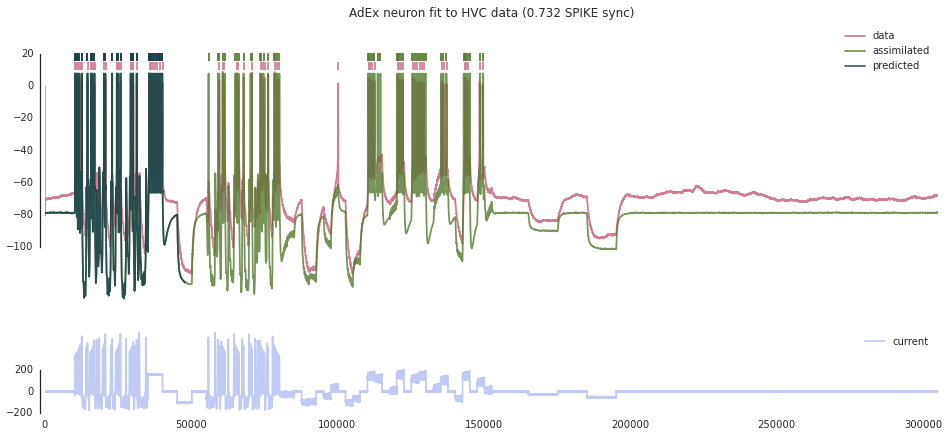

In [27]:
# integrate the model using the estimated parameters
bn = cn.adex(mC, mgl, mel, mdelt, mvt, mtw, ma, mvr, mb)
bn.h = 8
bn.apply_current(iapp_all,res)
zz = bn.simulate(allduration,dt)[:,0]

# get the spike times produced by the model
zspikes = det.send(zz)
zaspikes = det.send(zz[:steps])
zs = spk.SpikeTrain(zspikes,[0,allduration])

# set up a nice, wide canvas 
frame = figure(figsize=(16,7))

# plot the voltage traces of the real neuron and model
subplot2grid((4,1),(0,0),rowspan=3)
plot(v_all,color=clr_plt[2],label='data')
plot((zz),color=clr_plt[1],alpha=0.8,label='assimilated')
plot(((zz[:steps])),color=clr_plt[0],alpha=0.8,label='predicted')
xlim((0,len(v_all)))

# mark the spike times
vlines(vallspikes,max(v_all)+1,max(v_all)+6,color=clr_plt[2])
vlines(zspikes,max(v_all)+7,max(v_all)+12,clr_plt[1])
vlines(zaspikes,max(v_all)+7,max(v_all)+12,clr_plt[0])

# apply various aesthetic enhancements
xticks([0],[''])
yticks(range(-100,21,20))

legend(loc="best")

title("AdEx neuron fit to HVC data (%.3f SPIKE sync)" % spk.spike_sync(zs,vas))

# plot the applied current
subplot2grid((4,1),(3,0),rowspan=1)

plot(iapp_all,label='current',color=clr_plt[3])
legend(loc="best")
yticks(range(-200,400,200))
xlim((0,(len(v_all)*dt)/res))

# kill the spines
sns.despine(trim=True,offset=5,bottom=True)